In [7]:
import sys
sys.path.append("..")
from src import *
import pandas as pd
import numpy as np

In [8]:
import sqlite3
con = sqlite3.connect("covid-db")

In [9]:
df = pd.read_sql_query("select * from patients",con)

In [10]:
df

,location,country,gender,age,vis_wuhan,from_wuhan,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos,result
0,104,8,1,66.0,1,0,14,31,19,12,3,1,8,1
1,101,8,0,56.0,0,1,14,31,19,12,3,1,0,0
2,137,8,1,46.0,0,1,14,31,19,12,3,1,13,0
3,116,8,0,60.0,1,0,14,31,19,12,3,1,0,0
4,116,8,1,58.0,0,0,14,31,19,12,3,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
858,48,3,2,24.0,0,0,14,31,19,12,3,1,0,1
859,0,0,2,35.0,0,0,14,31,19,12,3,1,0,0
860,3,1,1,49.4,0,0,14,31,19,12,3,1,0,0
861,24,9,1,49.4,0,0,14,31,19,12,3,1,0,0


In [65]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
X = df.drop(['result'],axis=1)
y = df['result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)
print(f"shape of X_train: {X_train.shape}")
print(f"shape of X_test: {X_test.shape}")
print(f"shape of y_train: {y_train.shape}")
print(f"shape of y_test: {y_test.shape}")

shape of X_train: (690, 13)
shape of X_test: (173, 13)
shape of y_train: (690,)
shape of y_test: (173,)


In [66]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.compose import ColumnTransformer
import numpy as np

# Assuming X_train and y_train are defined

# Feature selection using F-test
f_test_selector = SelectKBest(score_func=f_classif, k=6)  # Adjust k as needed

# Feature selection using Mutual Information
mutual_info_selector = SelectKBest(score_func=mutual_info_classif, k=6)  # Adjust k as needed

# ColumnTransformer to handle transformations separately on X_train
preprocessor = ColumnTransformer(
    transformers=[
        ('f_test', f_test_selector, X_train.columns),
        ('mutual_info', mutual_info_selector, X_train.columns)
    ]
)

# Create the final pipeline for feature selection
pipeline_feature_selection = Pipeline([
    ('preprocessor', preprocessor)
])

# Fit and transform the data for feature selection
X_train_transformed = pipeline_feature_selection.fit_transform(X_train, y_train)
X_test_transformed = pipeline_feature_selection.transform(X_test)

# Get selected feature indices from both selectors
selected_features_f_test = pipeline_feature_selection.named_steps['preprocessor'].named_transformers_['f_test'].get_support(indices=True)
selected_features_mutual_info = pipeline_feature_selection.named_steps['preprocessor'].named_transformers_['mutual_info'].get_support(indices=True)

# Union of selected features
selected_features_union = np.union1d(selected_features_f_test, selected_features_mutual_info)
print(selected_features_union)
# Transform X_train and X_test based on the selected features union
X_train_union = X_train.iloc[:, selected_features_union]
X_test_union = X_test.iloc[:, selected_features_union]
selected_features_union.shape

[ 0  1  2  3  4  5  6 11 12]


(9,)

In [41]:
X_train.iloc[:,selected_features_union]

,location,country,age,vis_wuhan,from_wuhan,symptom1,symptom5,diff_sym_hos
560,19,32,49.4,1,0,14,3,0
161,27,11,49.4,0,0,14,3,0
443,108,24,29.0,0,0,14,3,0
234,1,18,65.0,0,0,6,3,0
150,99,8,48.0,0,0,14,3,2
...,...,...,...,...,...,...,...,...
732,45,13,38.0,0,0,14,3,0
695,45,13,57.0,0,0,14,3,0
454,108,24,34.0,0,0,14,3,0
537,114,29,49.4,1,0,14,3,0


In [70]:
from sklearn.preprocessing import StandardScaler
from umap import UMAP
preprocessor = Pipeline([
    ("UMAP",UMAP(n_components=3,
                           init='random',
                           random_state=2023,)),
    ("scaling",StandardScaler())
])


In [73]:
X_train_union

,location,country,gender,age,vis_wuhan,from_wuhan,symptom1,symptom6,diff_sym_hos
560,19,32,0,49.4,1,0,14,1,0
161,27,11,2,49.4,0,0,14,1,0
443,108,24,1,29.0,0,0,14,1,0
234,1,18,1,65.0,0,0,6,1,0
150,99,8,1,48.0,0,0,14,1,2
...,...,...,...,...,...,...,...,...,...
732,45,13,0,38.0,0,0,14,1,0
695,45,13,0,57.0,0,0,14,1,0
454,108,24,0,34.0,0,0,14,1,0
537,114,29,2,49.4,1,0,14,1,0


In [71]:
features = preprocessor.fit_transform(X_train_union,y_train)

E:\projects\COVID-Outcome-Prediction\venv\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [72]:
features

array([[ 1.8889172 ,  0.1935595 , -0.5497921 ],
       [ 0.6132821 ,  0.36662254, -1.153789  ],
       [-0.06468447, -1.0765722 ,  0.60862976],
       ...,
       [-0.06231092, -1.0454506 ,  0.6963742 ],
       [ 0.58701307,  1.6370366 ,  0.5583574 ],
       [ 2.3940287 , -4.581596  ,  0.27464002]], dtype=float32)

In [50]:
import mlflow
import mlflow.sklearn
import warnings as warn
import pandas as panda_obj
from sklearn.model_selection import train_test_split as tts, ParameterGrid as pg, GridSearchCV as gscv
import os
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score as acs, classification_report as cr
os.environ["GIT_PYTHON_REFRESH"] = "quiet"

In [48]:
mlflow.set_tracking_uri("http://localhost:5000")


In [49]:
adm_experiment_name = "Union-Features-FTest-Mutual"
mlflow.set_experiment(adm_experiment_name)

2023/12/14 11:15:55 INFO mlflow.tracking.fluent: Experiment with name 'Union-Features-FTest-Mutual' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/542480374940682006', creation_time=1702545355793, experiment_id='542480374940682006', last_update_time=1702545355793, lifecycle_stage='active', name='Union-Features-FTest-Mutual', tags={}>

In [67]:
y_train[y_train==0] = -1
y_train[y_train==1] = 1
y_test[y_test==0] = -1
y_test[y_test==1] = 1


In [68]:
y_train.unique()

array([-1,  1], dtype=int64)

In [74]:
y_train

560   -1
161   -1
443   -1
234   -1
150   -1
      ..
732   -1
695   -1
454   -1
537   -1
855   -1
Name: result, Length: 690, dtype: int64

In [75]:
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
svc_obj = SVC(random_state=2023)
param_grid = {
    'C' : [1, 5, 10,25,50],
    'kernel': ['linear', 'poly', 'rbf'],
    'class_weight':[{-1: 1.0, 1: weight} for weight in np.linspace(1, 10, 10)]
    
}
features_train = preprocessor.fit_transform(X_train_union,y_train)
features_test = preprocessor.transform(X_test_union)
with warn.catch_warnings():
    warn.filterwarnings("ignore", category=UserWarning, module='.*distutils.*')
    for params in pg(param_grid):
        with mlflow.start_run(run_name="Union-Features-FTest-Mutual Run"):
            # Convert single values to lists
            params = {key: [value] if not isinstance(value, list) else value for key, value in params.items()}
            mlflow.log_params(params)
            grid_search = gscv(svc_obj, param_grid=params, cv=5)
            grid_search.fit(features_train, y_train)
            std_best_model = grid_search.best_estimator_
            
            model_predictions = std_best_model.predict(features_test)
            model_accuracy_score = acs(y_test,model_predictions)
            model_f1_score = f1_score(y_test,model_predictions)
            fpr, tpr, _ = roc_curve(y_test, model_predictions)
            roc_auc = auc(fpr, tpr)
            print("Hyperparameters:", params)
            print("Accuracy:", model_accuracy_score)
            # Explicitly ignore the UndefinedMetricWarning
            with warn.catch_warnings():
                warn.filterwarnings("ignore", category=Warning)
                print("Classification Report:")
                print(cr(y_test, model_predictions, zero_division=1))
            mlflow.log_metric("accuracy", model_accuracy_score)
            mlflow.log_metric("f1-score",model_f1_score)
            mlflow.log_metric("roc-auc",roc_auc)
            mlflow.sklearn.log_model(std_best_model, "gb_classifier_model")

E:\projects\COVID-Outcome-Prediction\venv\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Hyperparameters: {'C': [1], 'class_weight': [{-1: 1.0, 1: 1.0}], 'kernel': ['linear']}
Accuracy: 0.815028901734104
Classification Report:
              precision    recall  f1-score   support

          -1       0.82      1.00      0.90       141
           1       1.00      0.00      0.00        32

    accuracy                           0.82       173
   macro avg       0.91      0.50      0.45       173
weighted avg       0.85      0.82      0.73       173

Hyperparameters: {'C': [1], 'class_weight': [{-1: 1.0, 1: 1.0}], 'kernel': ['poly']}
Accuracy: 0.815028901734104
Classification Report:
              precision    recall  f1-score   support

          -1       0.82      1.00      0.90       141
           1       1.00      0.00      0.00        32

    accuracy                           0.82       173
   macro avg       0.91      0.50      0.45       173
weighted avg       0.85      0.82      0.73       173

Hyperparameters: {'C': [1], 'class_weight': [{-1: 1.0, 1: 1.0}], 'kernel

In [76]:
import mlflow
logged_model = 'runs:/62a0fba0f43146cbb17428351884e9af/gb_classifier_model'
loaded_model = mlflow.pyfunc.load_model(logged_model)

              precision    recall  f1-score   support

          -1       0.95      0.93      0.94       141
           1       0.71      0.78      0.75        32

    accuracy                           0.90       173
   macro avg       0.83      0.86      0.84       173
weighted avg       0.91      0.90      0.90       173



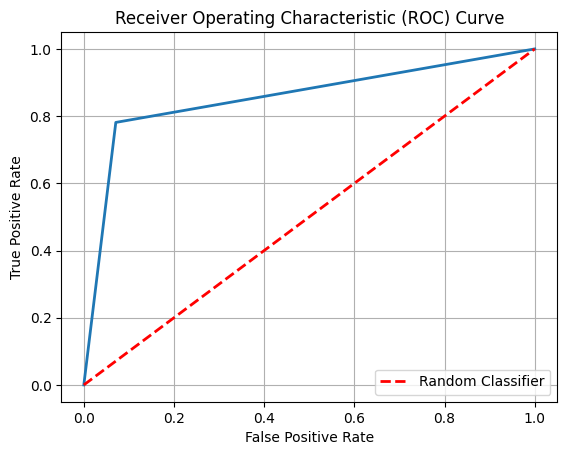

In [80]:
import matplotlib.pyplot as plt
model_predictions = loaded_model.predict(features_test)
model_accuracy_score = acs(y_test,model_predictions)
model_f1_score = f1_score(y_test,model_predictions)
print(cr(y_test, model_predictions, zero_division=1))
fpr, tpr, _ = roc_curve(y_test, model_predictions)
plt.plot(fpr, tpr, lw=2)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [82]:
acs(y_train,loaded_model.predict(features_train))

0.9202898550724637

In [83]:
model_accuracy_score

0.9017341040462428

- No overfitting
  